In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
K_MEANS = 3

train_df = pd.read_csv('./K_means/K_means_train.csv')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             151 non-null    int64  
 1   SepalLengthCm  151 non-null    float64
 2   SepalWidthCm   151 non-null    float64
 3   PetalLengthCm  151 non-null    float64
 4   PetalWidthCm   151 non-null    float64
 5   Labels         151 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None


In [3]:
# exclude Id row since pandas df has automatic indexing
train_x_df = train_df.iloc[:, 1:]
print(train_x_df)

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm   Labels
0              5.1           3.5            1.4           0.2  unlabel
1              4.9           3.0            1.4           0.2  unlabel
2              4.7           3.2            1.3           0.2  unlabel
3              4.6           3.1            1.5           0.2  unlabel
4              5.0           3.6            1.4           0.2  unlabel
..             ...           ...            ...           ...      ...
146            6.2           2.9            4.3           1.3  unlabel
147            6.3           2.5            5.0           1.9  unlabel
148            6.5           3.0            5.2           2.0  unlabel
149            6.2           3.4            5.4           2.3  unlabel
150            6.3           3.7            5.0           2.1  unlabel

[151 rows x 5 columns]


In [4]:
# randomly initialize centroids by picking K rows from data set
def initialize_centroids(k, x):
   return x.sample(n=k).set_index(pd.Index(range(1, k+1)))

# Euclidean distance compute method
def calc_dist(p, q):
   return np.linalg.norm(q - p)

# calculate the closest centroid for a given data row
def calc_closest_centroid(centroids, x_i):
   return centroids.apply(lambda centroid_i, x_i: calc_dist(x_i, centroid_i), axis=1, x_i=x_i).idxmin()

# calculate clusters for data set given set of centroids
def calc_clusters(centroids, x):
   # calculate closest centroid for each row of data
   x['Labels'] = x.apply(lambda x_i, centroids, cols: calc_closest_centroid(
       centroids.iloc[:, :cols], x_i.iloc[:cols]), axis=1, centroids=centroids, cols=x.shape[1]-1)
   return x

# calculate centroids based on given clustering
def calc_centroids(clusters_df):
   return clusters_df.groupby(['Labels']).apply(
       lambda cluster: cluster.mean(axis=0)).set_index('Labels')

# main method for calculating k-means, following algorithm
def calc_k_means(k, x):
   centroids = initialize_centroids(k, x)
   old_clusters_df, clusters_df = None, None

   # loop until convergence
   while clusters_df is None or not clusters_df.equals(old_clusters_df):
      if clusters_df is not None:
         old_clusters_df = clusters_df.copy(deep=True)
      # compute clusters using centroids from last iteration (or initialization)
      clusters_df = calc_clusters(centroids, x)
      # re-compute centroids based on new clusters
      centroids = calc_centroids(clusters_df)

   centroids.index = [f'cluster_{int(idx)}' for idx in centroids.index]
   return centroids

In [5]:
# compute k-means clusters using training data
centroids = calc_k_means(K_MEANS, train_x_df)
print(centroids)

           SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
cluster_1       6.835897      3.089744       5.723077      2.071795
cluster_2       5.901613      2.748387       4.393548      1.433871
cluster_3       5.006000      3.418000       1.464000      0.244000


In [6]:
valid_df = pd.read_csv('./K_means/K_means_valid.csv')
print(valid_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             6 non-null      int64  
 1   SepalLengthCm  6 non-null      float64
 2   SepalWidthCm   6 non-null      float64
 3   PetalLengthCm  6 non-null      float64
 4   PetalWidthCm   6 non-null      float64
 5   Labels         6 non-null      object 
dtypes: float64(4), int64(1), object(1)
memory usage: 416.0+ bytes
None


In [7]:
valid_x_df = valid_df.iloc[:, 1:]
valid_y_df = valid_df.loc[:, 'Labels']
print(valid_x_df)
print(valid_y_df)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Labels
0            4.8           3.0            1.4           0.3  cluster_1
1            5.1           3.8            1.6           0.2  cluster_1
2            5.1           2.5            3.0           1.1  cluster_2
3            5.7           2.8            4.1           1.3  cluster_2
4            6.7           3.0            5.2           2.3  cluster_3
5            6.7           3.3            5.7           2.5  cluster_3
0    cluster_1
1    cluster_1
2    cluster_2
3    cluster_2
4    cluster_3
5    cluster_3
Name: Labels, dtype: object


In [8]:
# use validation data to calculate clusters
valid_clusters_df = calc_clusters(centroids, valid_x_df)
# visually compare computed labels with validation labels
print(valid_clusters_df)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Labels
0            4.8           3.0            1.4           0.3  cluster_3
1            5.1           3.8            1.6           0.2  cluster_3
2            5.1           2.5            3.0           1.1  cluster_2
3            5.7           2.8            4.1           1.3  cluster_2
4            6.7           3.0            5.2           2.3  cluster_1
5            6.7           3.3            5.7           2.5  cluster_1


In [9]:
test_df = pd.read_csv('./K_means/K_means_test.csv')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10 non-null     int64  
 1   SepalLengthCm  10 non-null     float64
 2   SepalWidthCm   10 non-null     float64
 3   PetalLengthCm  10 non-null     float64
 4   PetalWidthCm   10 non-null     float64
 5   labels         10 non-null     object 
dtypes: float64(4), int64(1), object(1)
memory usage: 608.0+ bytes
None


In [10]:
test_x_df = test_df.iloc[:, 1:test_df.shape[1] - 1]
print(test_x_df)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0            4.6           3.2            1.4           0.2
1            5.3           3.7            1.5           0.2
2            5.0           3.3            1.4           0.2
3            5.7           3.0            4.2           1.2
4            5.7           2.9            4.2           1.3
5            6.2           2.9            4.3           1.3
6            6.3           2.5            5.0           1.9
7            6.5           3.0            5.2           2.0
8            6.2           3.4            5.4           2.3
9            6.3           3.7            5.0           2.1


In [11]:
test_clusters_df = calc_clusters(centroids, test_x_df)
print(test_clusters_df)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Labels
0            4.6           3.2            1.4           0.2  cluster_3
1            5.3           3.7            1.5           0.2  cluster_3
2            5.0           3.3            1.4           0.2  cluster_3
3            5.7           3.0            4.2           1.2  cluster_2
4            5.7           2.9            4.2           1.3  cluster_2
5            6.2           2.9            4.3           1.3  cluster_2
6            6.3           2.5            5.0           1.9  cluster_2
7            6.5           3.0            5.2           2.0  cluster_1
8            6.2           3.4            5.4           2.3  cluster_1
9            6.3           3.7            5.0           2.1  cluster_1


In [12]:
from sklearn.manifold import TSNE
import seaborn as sns

In [13]:
train_clusters_df = calc_clusters(centroids, train_x_df)
# combine training data clusters with test data clusters
tsne_df = train_clusters_df.append(test_clusters_df).reset_index().drop(columns=['index'])
print(tsne_df)

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Labels
0              5.1           3.5            1.4           0.2  cluster_3
1              4.9           3.0            1.4           0.2  cluster_3
2              4.7           3.2            1.3           0.2  cluster_3
3              4.6           3.1            1.5           0.2  cluster_3
4              5.0           3.6            1.4           0.2  cluster_3
..             ...           ...            ...           ...        ...
156            6.2           2.9            4.3           1.3  cluster_2
157            6.3           2.5            5.0           1.9  cluster_2
158            6.5           3.0            5.2           2.0  cluster_1
159            6.2           3.4            5.4           2.3  cluster_1
160            6.3           3.7            5.0           2.1  cluster_1

[161 rows x 5 columns]


In [14]:
model = TSNE(learning_rate=50)

# keep just the numeric values of the TSNE dataframe
tsne_clusters_numeric = tsne_df.sort_values(by='Labels').drop('Labels', axis=1)
# train the TSNE model based on the numeric TSNE dataframe
tsne_features = model.fit_transform(tsne_clusters_numeric)

# make a new dataframe containing the features computed by the TSNE model
tsne_clusters_df = pd.DataFrame(
    {'x': tsne_features[:, 0], 'y': tsne_features[:, 1], 'species': tsne_df['Labels'].sort_values()})
print(tsne_clusters_df)

             x          y    species
160  -7.366347   3.342569  cluster_1
122  -9.704874   4.293253  cluster_1
121 -12.865875   1.750458  cluster_1
120 -11.480424   1.313946  cluster_1
119 -10.835701   1.520998  cluster_1
..         ...        ...        ...
22   15.554276 -10.518478  cluster_3
21   18.969955  -9.995660  cluster_3
20   19.954098 -11.160086  cluster_3
31   19.740452 -11.101984  cluster_3
0    18.356691 -10.684797  cluster_3

[161 rows x 3 columns]


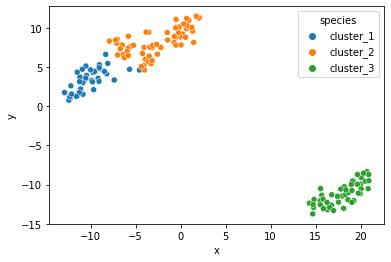

In [15]:
# create seaborn scatterplot
sns.scatterplot(x='x', y='y', hue='species', data=tsne_clusters_df)
plt.show()